In [1]:
import numpy as np
from theano import config

a = 5 
b = 2
N = 2000
s_noise = 0.02

x0 = np.linspace(-3.0, 3.0, num=N);
x1 = np.sin(b * x0)
x2 = np.cos(a * x0)

fx = 0.1 * x2 + 0.1 *x1 + 0.4

fx_str = '$f(x)=cos({%g x}) + sin({%g x})$' % (a, b)

nu = np.random.randn(N,) * s_noise
nu[np.random.rand(N,) > 0.95] += 0.2

z = fx + nu

n_train = int(N * 0.5)
i_test = N - n_train

w = 1
Y = z[w:]
X = z[:-w]

# X = (X - np.mean(X, axis=0)) / np.var(X, axis=0)

y_train = Y[:n_train][:,np.newaxis]
y_test = Y[n_train:][:,np.newaxis]
X_train = X[:n_train][:,np.newaxis]
X_test = X[n_train:][:,np.newaxis]

fx_train = fx[:n_train][:,np.newaxis]
fx_test = fx[n_train:-w][:,np.newaxis]

SNR = np.mean(z) / np.std(z)

print('SNR: %g' % SNR)

SNR: 3.69827


<IPython.core.display.Javascript object>


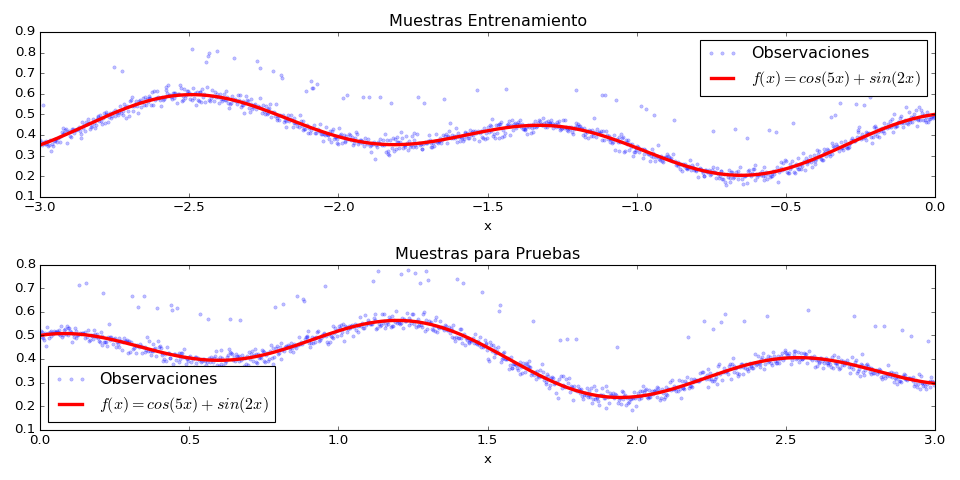

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=80)
ax = plt.subplot(211)
t = x0[:-w]
ax.plot(t[:n_train], y_train, 'b.', alpha=0.25, label='Observaciones')
ax.plot(t[:n_train], fx_train, '-r', lw=3, label=fx_str)
plt.title('Muestras Entrenamiento')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

ax = plt.subplot(212)
ax.plot(t[n_train:], y_test, 'b.', alpha=0.25, label='Observaciones')
ax.plot(t[n_train:], fx_test, '-r', lw=3, label=fx_str)
plt.title('Muestras para Pruebas')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.layers.recurrent import RecurrentLayer
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *
from deepensemble.metrics import *
from deepensemble.utils import *

n_neurons = 5
n_models = 4
lr = 0.01
batch_size = 100
max_epoch = 300
valid_size=0.5
no_update_best_parameters=True
fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.sigmoid

In [4]:
# Create Ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation2))
    net.append_cost(mse, name='MSE')
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensemble.append_model(net)

ensemble.set_combiner(AverageCombiner())
ensemble.compile(fast=True)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)
                      
# training
metrics = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size,
                       early_stop=False, valid_size=valid_size,
                       no_update_best_parameters=no_update_best_parameters)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Start Compile Ensemble  - elapsed: 12.20 [s]
Ensemble - fold: 1, epoch:[####################] 300/300 elapsed: 9.52[s] - left: 0.00[s] | score: 0.0092 / 0.0312
FINISHED!


In [5]:
# Create Ensemble NCL
ensembleNCL = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation2))
    net.append_cost(mse, name='MSE')
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensembleNCL.append_model(net)

ensembleNCL.add_cost_ensemble(fun_cost=neg_corr, name="NEG_CORR", lamb=0.1)
ensembleNCL.set_combiner(AverageCombiner())
ensembleNCL.compile(fast=True)

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size,
                         early_stop=False, valid_size=valid_size,
                         no_update_best_parameters=no_update_best_parameters)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Start Compile Ensemble  - elapsed: 14.90 [s]
Ensemble - fold: 1, epoch:[####################] 300/300 elapsed: 8.70[s] - left: 0.00[s] | score: 0.0049 / 0.0136
FINISHED!


In [6]:
# Create MLP

mlp = Sequential("MLP")  # by default is a regressor
mlp.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
mlp.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation2))
mlp.append_cost(mse, name='MSE')
mlp.set_update(sgd, name='SGD', learning_rate=lr/100)

mlp.compile(fast=True)

metrics_mlp = FactoryMetrics.get_metric(mlp)
                      
# training
metrics = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size,
                 early_stop=False, valid_size=valid_size,
                 no_update_best_parameters=no_update_best_parameters)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Start Compile MLP  - elapsed: 3.51 [s]
MLP - fold: 1, epoch:[####################] 300/300 elapsed: 3.64[s] - left: 0.00[s] | score: 0.0134 / 0.0432
FINISHED!


In [7]:
# Create Ensemble KLG
ensembleKLG = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation2))
    net.append_cost(kullback_leibler, name="KLG")
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensembleKLG.append_model(net)

ensembleKLG.add_cost_ensemble(fun_cost=neg_correntropy, name="NEG_CORRPY", lamb=-0.2)
ensembleKLG.set_combiner(AverageCombiner())
ensembleKLG.compile(fast=True)

metrics_ensembleKLG = FactoryMetrics.get_metric(ensembleKLG)
                      
# training
metrics = ensembleKLG.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, 
                         early_stop=False, valid_size=valid_size,
                         no_update_best_parameters=no_update_best_parameters)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleKLG.append_metric(metrics)

Start Compile Ensemble  - elapsed: 32.38 [s]
Ensemble - fold: 1, epoch:[####################] 300/300 elapsed: 8.90[s] - left: 0.00[s] | score: 0.0309 / 0.0859
FINISHED!


<IPython.core.display.Javascript object>


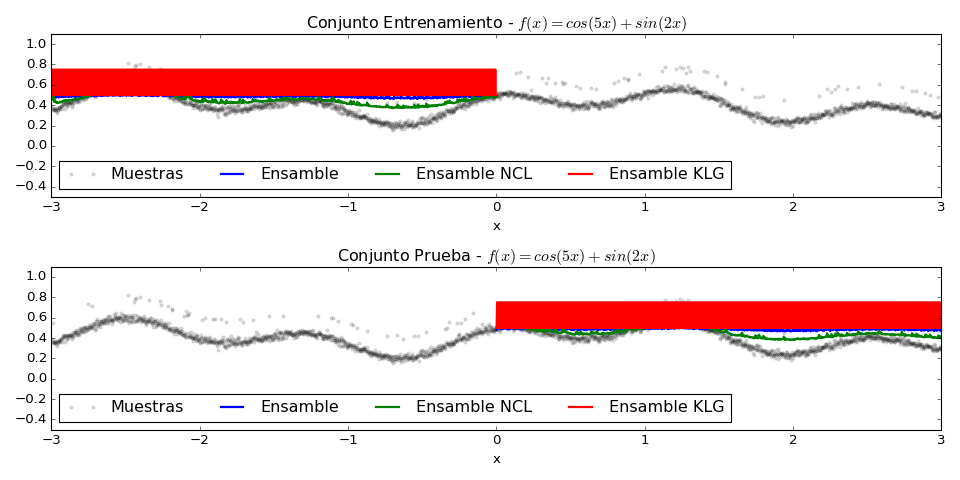

In [8]:
fig = plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(211)
plt.plot(x0, z, 'k.', alpha=0.15,  label='Muestras')
plt.plot(t[:n_train], ensemble.predict(X_train), lw=2, label='Ensamble')
plt.plot(t[:n_train], ensembleNCL.predict(X_train), lw=2, label='Ensamble NCL')
plt.plot(t[:n_train], ensembleKLG.predict(X_train), lw=2, label='Ensamble KLG')
# plt.plot(t[:n_train], mlp.predict(X_train), lw=2, label='MLP')
plt.title('Conjunto Entrenamiento - %s' % fx_str)
plt.xlabel('x')
plt.xlim([-3,3])
plt.ylim([-0.5,1.1])
plt.legend(loc='best', ncol=5)

plt.subplot(212)
plt.plot(x0, z, 'k.', alpha=0.15, label='Muestras')
plt.plot(t[n_train:], ensemble.predict(X_test), lw=2, label='Ensamble')
plt.plot(t[n_train:], ensembleNCL.predict(X_test), lw=2, label='Ensamble NCL')
plt.plot(t[n_train:], ensembleKLG.predict(X_test), lw=2, label='Ensamble KLG')
# plt.plot(t[n_train:], mlp.predict(X_test), lw=2, label='MLP')
plt.title('Conjunto Prueba - %s' % fx_str)
plt.xlabel('x')
plt.xlim([-3,3])
plt.ylim([-0.5,1.1])
plt.legend(loc='best', ncol=5)

plt.tight_layout()

<IPython.core.display.Javascript object>


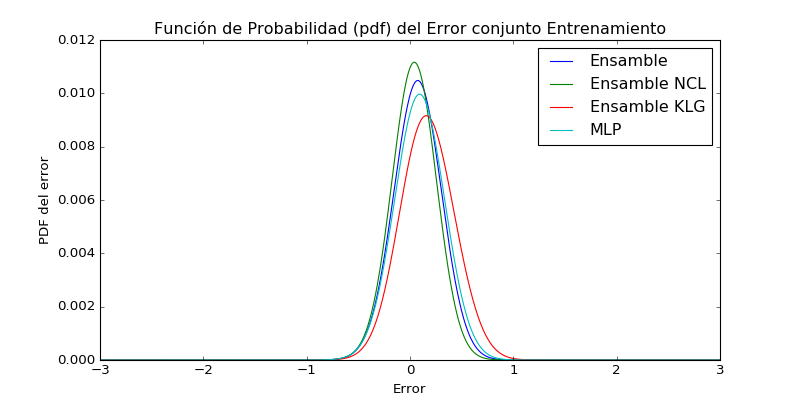

In [9]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-3, xmax=3):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(10, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_train), y_train, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_train), y_train, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleKLG.predict(X_train), y_train, 'Ensamble KLG', ax, fig)
plot_pdf_error(mlp.predict(X_train), y_train, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

<IPython.core.display.Javascript object>


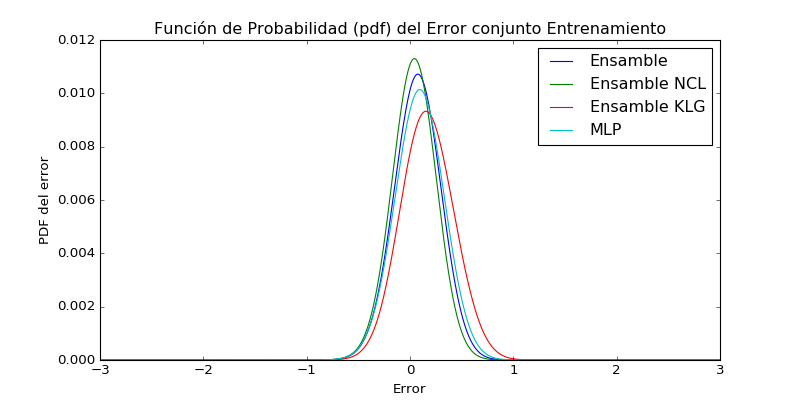

In [10]:
fig = plt.figure(figsize=(10, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_test), y_test, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_test), y_test, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleKLG.predict(X_test), y_test, 'Ensamble KLG', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

In [11]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleKLG = ensembleKLG.score(X_test, y_test)
score_train_ensembleKLG = ensembleKLG.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble KLG: %f / %f' % (score_train_ensembleKLG, score_test_ensembleKLG))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble: 0.017586 / 0.015282
Ensamble NCL: 0.007833 / 0.006791
Ensamble KLG: 0.056139 / 0.053168
MLP: 0.026096 / 0.024055
